# `Setup`

In [ ]:
# @title #### Import dependencies
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import os

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

!mkdir figures # for saving plots

!pip install matplotlib_inline
!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

mkdir: cannot create directory ‘figures’: File exists


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset

# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math

# @title #### Import dependencies
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import os

import torch
from torch import nn
from torch.nn import functional as F
import torchvision


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'aml_itu/'
/content/aml_itu
From https://github.com/RasKrebs/aml_itu
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content/aml_itu
GPU is available


### `Config`

In [ ]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))

# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/imgs/train',
   'test': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `Finetuned Models`

In [ ]:
# IMG Transformations
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])

transforms = {
    'train': v2.Compose([
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(),
    v2.ToDtype(torch.float32, scale=True),
    normalize]),
    'val': v2.Compose([
    v2.Resize(size=256, antialias=True),
    v2.CenterCrop(size=224),
    v2.ToDtype(torch.float32, scale=True),
    normalize])}



# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [ ]:
# Normal Dataset
# Creating the dataset
train_data = StateFarmDataset(config,
                              transform=transforms['train'],
                              split='train',
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config,
                            transform=transforms['val'],
                            split='val',
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config,
                            split='test',
                            transform=transforms['val'],
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 14409
Lenght of val data: 3345
Lenght of val data: 4670


In [ ]:
# Create subsets of the train_data and val_data
#train_data = torch.utils.data.Subset(train_data, range(0, 1000))
#val_data = torch.utils.data.Subset(val_data, range(0, 1000))


# Create dataloaders dict with subsets of the data
batch_size = 16


dataloaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_data, batch_size=batch_size, shuffle=True),
    'test': DataLoader(test_data, batch_size=batch_size, shuffle=True)
}

In [ ]:
# Displaying training data including transformations
#train_data.display_classes(id_to_class=True)

#### `Model`

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Sequential(
            nn.BatchNorm1d(finetune_net.fc.in_features, 512),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=10)
)


#nn.Linear(finetune_net.fc.in_features, 10)





nn.init.xavier_uniform_(finetune_net.fc[-1].weight)


Parameter containing:
tensor([[ 0.0341,  0.0821,  0.0580,  ..., -0.0656,  0.0923, -0.1066],
        [ 0.0962,  0.0195,  0.0622,  ..., -0.0077,  0.0236, -0.0940],
        [ 0.0907,  0.0679, -0.0397,  ...,  0.0044, -0.0130, -0.0959],
        ...,
        [-0.0207, -0.0816,  0.0249,  ..., -0.0132, -0.0243,  0.0881],
        [ 0.0107, -0.0677,  0.0528,  ...,  0.0544, -0.0209, -0.0982],
        [ 0.1061,  0.0026, -0.0794,  ..., -0.0407, -0.0693,  0.1033]],
       requires_grad=True)

In [ ]:
def train_batch(net, X, y, loss, trainer, devices):
    X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    #net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net = net.to(devices[0])
    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [ ]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=25,
                      param_group=True):
    train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_iter = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    devices = ['cuda']
    loss = nn.CrossEntropyLoss(reduction="none")

    if param_group:
        fc_params = set(list(net.fc.parameters()))
        params_1x = [param for name, param in net.named_parameters() if param not in fc_params]
        trainer = torch.optim.SGD([
            {'params': params_1x},
            {'params': net.fc.parameters(), 'lr': learning_rate * 10}
        ], lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.01)

    train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


loss 0.318, train acc 0.961, test acc 0.821
347.0 examples/sec on ['cuda']


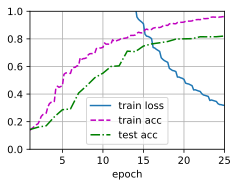

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

In [129]:
net = finetune_net.to('cuda')


In [131]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients during testing
      for images, label_tuple in test_loader:
          labels = [label_map[label.item()] if label.item() in label_map else -1 for label in label_tuple]
          labels = torch.tensor(labels, dtype=torch.long)
          images, labels = images.to(device), labels.to(device)


          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total_predictions += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()

    accuracy = 100 * correct_predictions / total_predictions
    print(f'Accuracy on test set: {accuracy:.2f}%')


In [ ]:
label_map = {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}

# Test the model
test_model(net, dataloaders['test'])